

##Implementing a plain end2end tensorflow model pipeline with EDA and visualizations



In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 3.8MB/s 
     |████████████████████████████████| 15.3MB 277kB/s 
     |████████████████████████████████| 6.5MB 32.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
import tensorflow as tf
import requests
from io import BytesIO
import tensorflow.keras as keras
print(tf.__version__)


device="gpu"

if device=="tpu":
  resolver=tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://'+ os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  startegy=tf.distributre.experimental.TPUStartegy(resolver)
else:
  startegy=tf.distribute.MultiWorkerMirroredStrategy()

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


Fetching sample data for Preprocessing

In [4]:
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQvz0ov4yTHiXb-afU3DusUgY1Te8R5OfTnXSdl5tPYVK_c2fesdYve1dhTcA2jbziBurSzinFJQ5QQ/pub?gid=475529327&single=true&output=csv')
file = r.content

df = pd.read_csv(BytesIO(file))


In [5]:
df.tail(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
14989,2009-04-03 10:50:05,18.9,2009-04-03 10:50:05 UTC,-73.978116,40.741562,-74.015378,40.711423,1
14990,2012-12-03 21:50:39,7.5,2012-12-03 21:50:39 UTC,-73.985420,40.752925,-73.969728,40.753033,1
14991,2013-12-22 18:31:24,4.5,2013-12-22 18:31:24 UTC,-73.987674,40.770579,-73.978944,40.777515,1
14992,2014-04-26 23:16:16,8.5,2014-04-26 23:16:16 UTC,-74.008603,40.721865,-73.996111,40.721818,1
14993,2009-09-26 0:52:32,16.1,2009-09-26 00:52:32 UTC,-74.001012,40.736762,-73.974030,40.783069,2
14994,2014-08-04 20:10:27,6.0,2014-08-04 20:10:27 UTC,-73.978600,40.744930,-73.991182,40.750237,1
14995,2015-02-08 19:18:16,8.5,2015-02-08 19:18:16 UTC,-73.995781,40.742569,-73.997551,40.719509,1
14996,2011-03-24 15:00:00,9.7,2011-03-24 15:00:00 UTC,-73.970910,40.761350,-73.976352,40.744828,5
14997,2013-07-22 22:16:21,9.5,2013-07-22 22:16:21 UTC,-73.980387,40.742480,-74.003918,40.731705,1
14998,2013-09-14 3:42:38,6.0,2013-09-14 03:42:38 UTC,-73.969019,40.761372,-73.980987,40.744484,1


In [6]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                14999 non-null  object 
 1   fare_amount        14999 non-null  float64
 2   pickup_datetime    14999 non-null  object 
 3   pickup_longitude   14999 non-null  float64
 4   pickup_latitude    14999 non-null  float64
 5   dropoff_longitude  14999 non-null  float64
 6   dropoff_latitude   14999 non-null  float64
 7   passenger_count    14999 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 937.6+ KB


In [7]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df.nunique()

key                  14964
fare_amount            449
pickup_datetime      14964
pickup_longitude     12973
pickup_latitude      13394
dropoff_longitude    13091
dropoff_latitude     13415
passenger_count          7
dtype: int64

In [9]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])


In [10]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 0:35:00,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 4:30:42,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 7:51:00,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
# extracting day_name, weekday, hour , month from pickup_datetime and dropdate_time
df['pickup_day']=df['pickup_datetime'].dt.day_name()
#df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
#df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
#df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
#df['dropoff_month']=df['dropoff_datetime'].dt.month

In [12]:
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                14999 non-null  object             
 1   fare_amount        14999 non-null  float64            
 2   pickup_datetime    14999 non-null  datetime64[ns, UTC]
 3   pickup_longitude   14999 non-null  float64            
 4   pickup_latitude    14999 non-null  float64            
 5   dropoff_longitude  14999 non-null  float64            
 6   dropoff_latitude   14999 non-null  float64            
 7   passenger_count    14999 non-null  int64              
 8   pickup_day         14999 non-null  object             
 9   pickup_day_no      14999 non-null  int64              
 10  pickup_hour        14999 non-null  int64              
 11  pickup_month       14999 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(4

In [14]:
df=df.drop(columns=['key','pickup_datetime'])
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_day_no,pickup_hour,pickup_month
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,Monday,0,17,6
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,Tuesday,1,16,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,Thursday,3,0,8
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,Saturday,5,4,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,Tuesday,1,7,3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


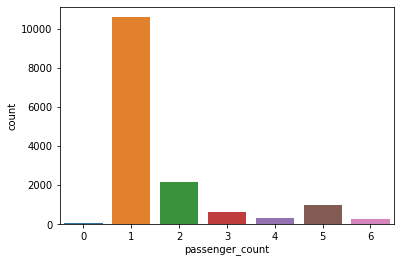

In [15]:
#Plot to check passenger count
sns.countplot(df['passenger_count'])

In [16]:
df['pickup_hour']=df['pickup_hour'].astype('str')
df['pickup_day_no']=df['pickup_day_no'].astype('str')
df['pickup_month']=df['pickup_month'].astype('str')

In [17]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean_distance(df):
  # print(row)
  a = (df['pickup_latitude'], df['pickup_longitude'])
  b = (df['dropoff_latitude'], df['dropoff_longitude'])
  df['distance'] = distance.euclidean(a, b) * 100
  return df

df = df.apply(euclidean_distance, axis=1)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_day_no,pickup_hour,pickup_month,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,Monday,0,17,6,0.943584
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,Tuesday,1,16,1,7.969567
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,Thursday,3,0,8,1.367404
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,Saturday,5,4,4,2.534047
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,Tuesday,1,7,3,1.946952


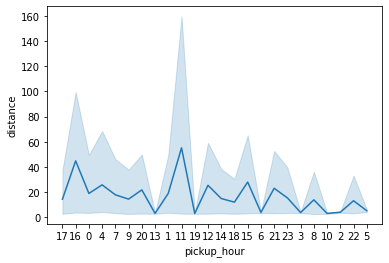

In [18]:
#Plot between trip distance per hour
sns.lineplot(x=df['pickup_hour'],y=df['distance'])

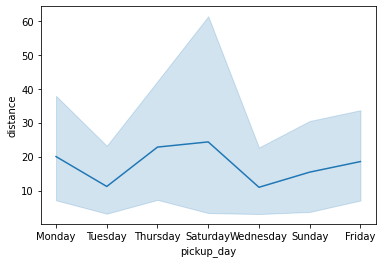

In [19]:
#Line plot to visualize trip distance each day
sns.lineplot(x=df['pickup_day'],y=df['distance'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


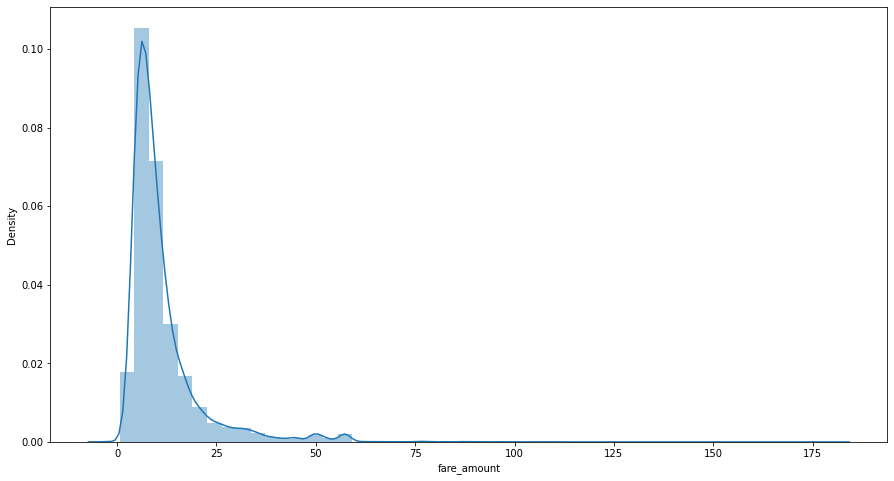

In [20]:
# plot to visualize fare distribution
plt.figure(figsize=(15, 8))
sns.distplot(df['fare_amount'])

In [21]:
df = df.drop(df[df['fare_amount'] > 75].index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


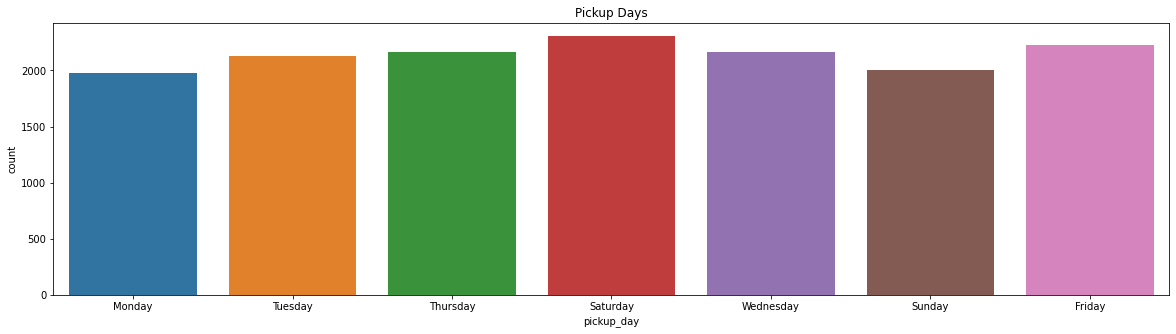

In [22]:
#Trips per day 
figure,(ax1)=plt.subplots(ncols=1,figsize=(20,5))
ax1.set_title('Pickup Days')
sns.countplot(df['pickup_day'],ax=ax1)
# ax2.set_title('Drop_off Days')
# sns.countplot(df['dropoff_day'],ax=ax2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


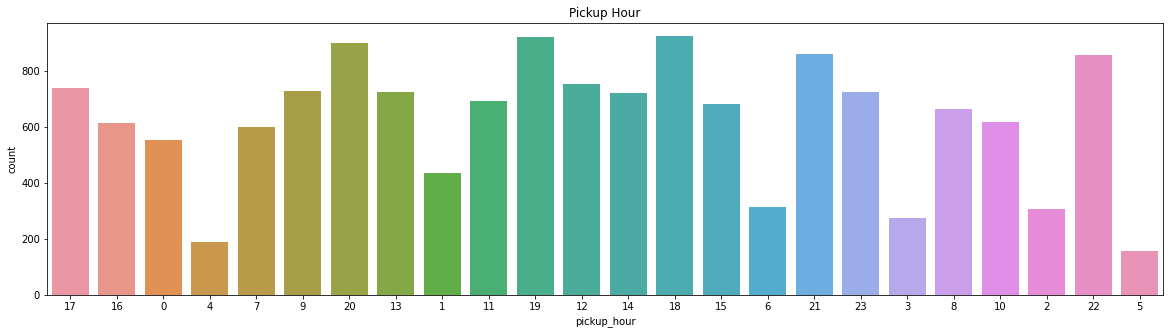

In [23]:
#Trips per hour
figure,(ax1)=plt.subplots(ncols=1,figsize=(20,5))
ax1.set_title('Pickup Hour')
sns.countplot(df['pickup_hour'],ax=ax1)
# ax2.set_title('Drop_off Hour')
# sns.countplot(df['dropoff_hour'],ax=ax2)

In [24]:
# Folium Map visualization
f_map=folium.Map()
sw = df[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = df[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
f_map.add_child(plugins.HeatMap(zip(df['pickup_latitude'], df['pickup_longitude'], df['fare_amount']), radius = 10))
f_map.fit_bounds([sw, ne])
f_map


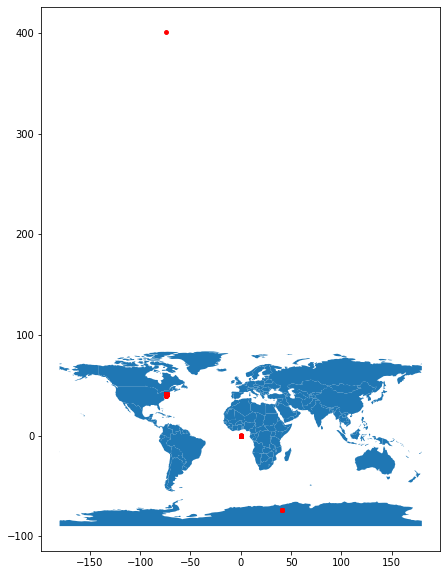

In [25]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15,10)), marker='o', color='red', markersize=15);

In [26]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,14978.000000,14978.000000,14978.000000,14978.000000,14978.000000,14978.000000,14978.000000
mean,11.162270,-72.461579,39.913853,-72.456065,39.890347,1.641140,17.716095
std,9.045124,10.590699,6.899333,10.603661,6.235843,1.265199,429.556134
min,-3.000000,-74.438233,-74.006893,-74.227047,-74.006377,0.000000,0.000000
25%,6.000000,-73.992167,40.734750,-73.991173,40.734765,1.000000,1.235698
50%,8.500000,-73.981697,40.752636,-73.980123,40.753704,1.000000,2.146870
75%,12.500000,-73.966767,40.767449,-73.963634,40.768107,2.000000,3.832517
max,75.000000,40.766125,401.083332,40.802437,41.366138,6.000000,36030.440502


In [27]:
# # Plot to visualize location wrt longitude AND Latitude
# geometry = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
# gdf = GeoDataFrame(df, geometry=geometry)   

# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(figsize=(15,10)), marker='o', color='red', markersize=15);

In [28]:
df=df.drop(df[df['distance'] > 1000].index)
#f = df.drop(df[(df.score < 50) & (df.score > 20)].index)
#df = df[df.distance <100]

In [29]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,14955.000000,14955.000000,14955.000000,14955.000000,14955.000000,14955.000000,14955.000000
mean,11.156446,-72.508727,39.915718,-72.507599,39.916221,1.641324,3.400676
std,9.032197,10.431683,6.155089,10.431558,6.154997,1.265272,4.740917
min,-3.000000,-74.438233,-74.006893,-74.227047,-74.006377,0.000000,0.000000
25%,6.000000,-73.992180,40.734814,-73.991175,40.734859,1.000000,1.233964
50%,8.500000,-73.981720,40.752645,-73.980133,40.753725,1.000000,2.144037
75%,12.500000,-73.966801,40.767475,-73.963666,40.768108,2.000000,3.818714
max,75.000000,40.766125,41.366138,40.802437,41.366138,6.000000,116.867277


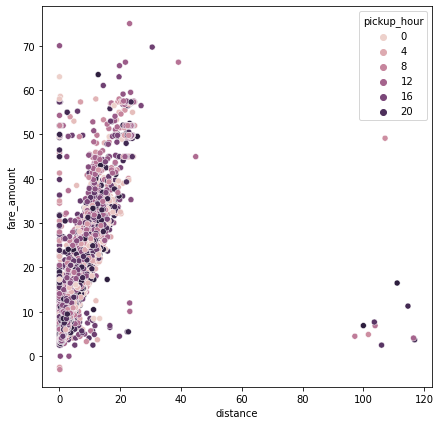

In [30]:
##fare Vs trip_distance plot( Colored by Pickup Hour )
plt.figure(figsize=(7,7))
sns.scatterplot(x=df['distance'], y=df['fare_amount'], hue=df['pickup_hour'].astype(int))

In [31]:
df=df.drop(columns=['pickup_day','geometry'])

In [32]:
df.head()  

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day_no,pickup_hour,pickup_month,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,0.943584
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,7.969567
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,1.367404
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2.534047
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,1.946952


In [33]:
df.to_csv("cleaned_data.csv", index=False)

In [34]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day_no,pickup_hour,pickup_month,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,0.943584
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,7.969567
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,1.367404
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2.534047
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,1.946952


In [35]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
df_train = df[msk]
df_test = df[~msk]

print(len(df_train))
print(len(df_test))

df.to_csv("train.csv", index=False, header=False)
df.to_csv("eval.csv", index=False, header=False)
df.head()

12705
2250


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day_no,pickup_hour,pickup_month,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,0.943584
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,7.969567
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,1.367404
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2.534047
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,1.946952


In [36]:
# plt.figure(figsize=(15, 8))
# sns.distplot(df['distance'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12705 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        12705 non-null  float64
 1   pickup_longitude   12705 non-null  float64
 2   pickup_latitude    12705 non-null  float64
 3   dropoff_longitude  12705 non-null  float64
 4   dropoff_latitude   12705 non-null  float64
 5   passenger_count    12705 non-null  int64  
 6   pickup_day_no      12705 non-null  object 
 7   pickup_hour        12705 non-null  object 
 8   pickup_month       12705 non-null  object 
 9   distance           12705 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.1+ MB


In [37]:
########## Defining feature functions for pipeline ###########
def feature_func(attr,label=None):
  # attr['longitude_dist'] = tf.abs(attr['pickup_longitude'] - attr['dropoff_longitude'])
  # attr['latitude_dist'] = tf.abs(attr['pickup_latitude'] - attr['dropoff_latitude'])
  attr['distance']=tf.sqrt(tf.abs(attr['pickup_longitude'] - attr['dropoff_longitude'])**2 + tf.abs(attr['pickup_latitude'] - attr['dropoff_latitude'])**2)
  attr['pickup_month'] = (tf.strings.substr(attr['pickup_datetime'], 5, 2))
  attr['pickup_day_no'] = (tf.strings.substr(attr['pickup_datetime'], 8, 2))
  attr['pickup_hour'] = (tf.strings.substr(attr['pickup_datetime'], 11, 2))
  # attr['distance'] = ((attr['pickup_latitude'] - attr['dropoff_latitude'])**2 +  (attr['pickup_longitude'] - attr['dropoff_longitude'])**2)**0.5
  
  if label == None:
        return attr
  return (attr, label)
#   return(attr)
# # Function to be called from Tensorflow
# def tf_feature_func(attr,label):
#   attr=feature_func(attr)
#   return(attr,label)

In [38]:
CSV_COLUMNS=['fare_amount', 'pickup_datetime','pickup_longitude','pickup_latitude',
               'dropoff_longitude','dropoff_latitude', 'passenger_count', ]
#CSV_COLUMNS=df_train.columns
LABEL_COLUMN='fare_amount'
TRAIN_LINES=25000
# Set default values for each CSV column( Including Y column )
#DEFAULTS = [['1'],[0.0],['1'],[0.0],[0.0], [0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            #select_columns = [1,2, 3, 4, 5, 6, 7] 
        else:
            num_epochs = 1 # end-of-input after this  
            #select_columns=[2, 3, 4, 5, 6,7]
        
                      
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=None,
                                                   column_defaults=None,
                                                   #select_columns=select_columns,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   header=True,
                                                   num_parallel_reads=30)
        
       #dataset = dataset.prefetch(buffer_size = batch_size)

        

        skip_train_lines = TRAIN_LINES // batch_size // 100 * 10 #skip first 10% lines of train data set
        if mode == tf.estimator.ModeKeys.TRAIN:
#    dataset = dataset.filter(filter_data)
            dataset = dataset.skip(skip_train_lines)
        elif mode == tf.estimator.ModeKeys.EVAL:
            dataset = dataset.take(skip_train_lines) 
       #Feature engineering
        dataset = dataset.map(feature_func)

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [39]:
!head -5 "/content/drive/MyDrive/cmpe-258/new-york-city-taxi-fare-prediction/train.csv"

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1


In [40]:
eval_file = "/content/drive/MyDrive/cmpe-258/new-york-city-taxi-fare-prediction/train1.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('key', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2009-10-10 14:05:00.00000017', b'2015-01-16 07:46:00.0000004',
       b'2013-11-23 15:29:00.00000049', b'2010-10-05 07:22:17.0000002',
       b'2010-03-11 07:10:44.0000004', b'2013-09-04 12:05:00.000000204',
       b'2012-11-16 12:42:29.0000003', b'2013-05-19 02:18:01.0000004',
       b'2015-05-01 15:58:46.0000005', b'2012-04-09 01:48:00.00000023'],
      dtype=object)>), ('pickup_datetime', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2009-10-10 14:05:00 UTC', b'2015-01-16 07:46:00 UTC',
       b'2013-11-23 15:29:00 UTC', b'2010-10-05 07:22:17 UTC',
       b'2010-03-11 07:10:44 UTC', b'2013-09-04 12:05:00 UTC',
       b'2012-11-16 12:42:29 UTC', b'2013-05-19 02:18:01 UTC',
       b'2015-05-01 15:58:46 UTC', b'2012-04-09 01:48:00 UTC'],
      dtype=object)>), ('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.98869 , -73.98262 , -73.99394 , -73.999504, -74.00026 ,
       -

<DatasetV1Adapter shapes: (OrderedDict([(key, (None,)), (pickup_datetime, (None,)), (pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (passenger_count, (None,)), (distance, (None,)), (pickup_month, (None,)), (pickup_day_no, (None,)), (pickup_hour, (None,))]), (None,)), types: (OrderedDict([(key, tf.string), (pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.int32), (distance, tf.float32), (pickup_month, tf.string), (pickup_day_no, tf.string), (pickup_hour, tf.string)]), tf.float32)>

In [41]:
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='pickup_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='pickup_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='pickup_day_no', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'pickup_month': k_month, 'pickup_hour': k_hour, 'pickup_day_no' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_day_no': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'pickup_day_no')>,
  'pickup_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'pickup_hour')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'pickup_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'pickup_month')>}}

In [42]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['pickup_day_no'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['pickup_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['pickup_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['pickup_day_no'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['pickup_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['pickup_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.0001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [43]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='rmse', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

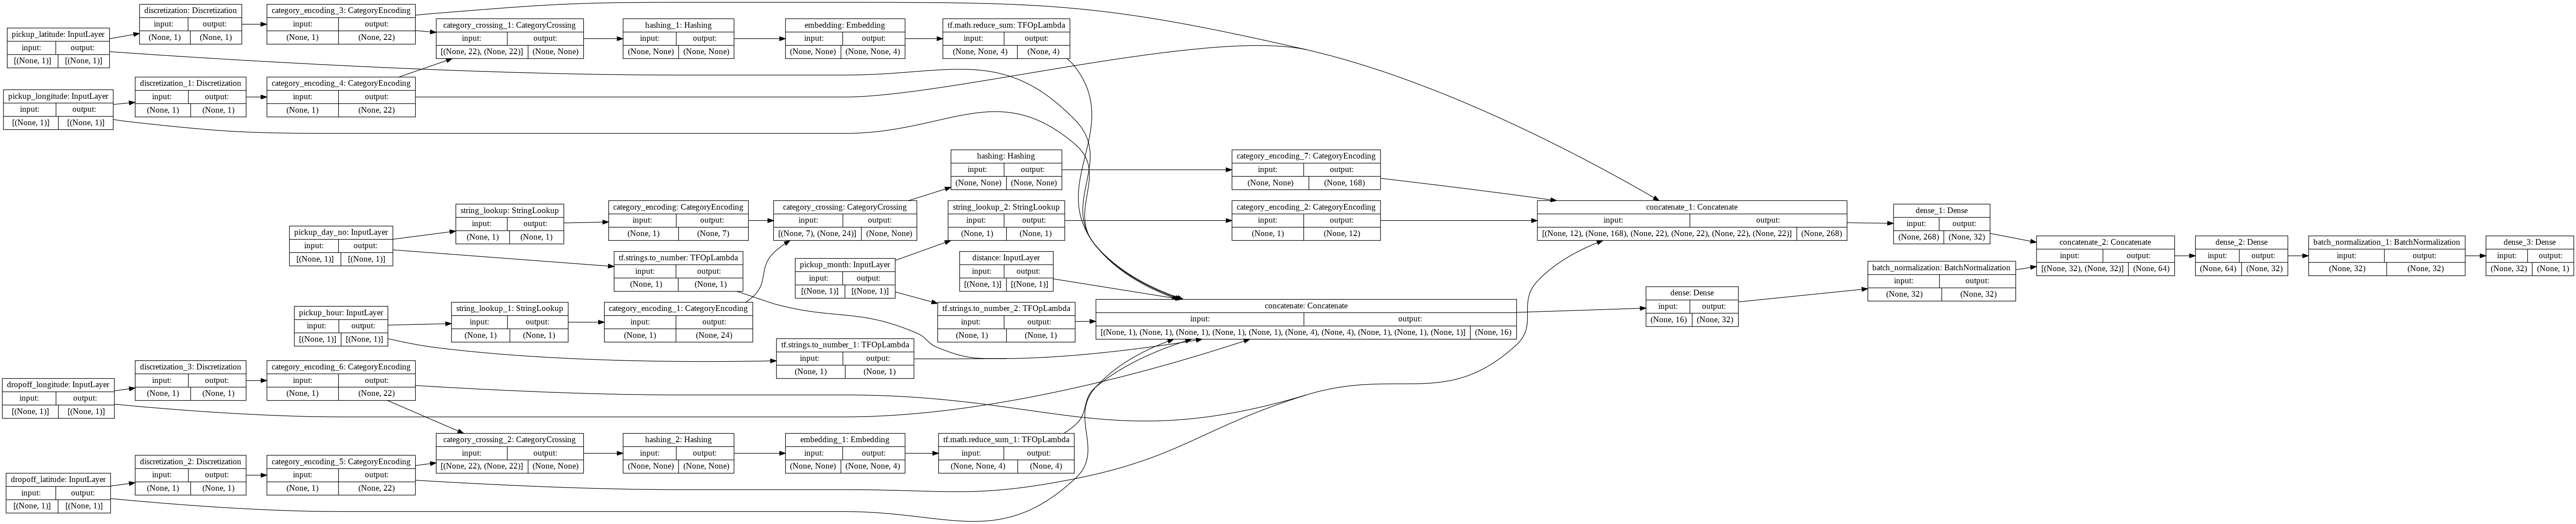

In [44]:
#Create dataset input functions
train_dataset = make_input_fn(filename = '/content/drive/MyDrive/cmpe-258/new-york-city-taxi-fare-prediction/train_file.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = '/content/drive/MyDrive/cmpe-258/new-york-city-taxi-fare-prediction/train_file.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [45]:
!head -5 /content/drive/MyDrive/cmpe-258/new-york-city-taxi-fare-prediction/train1.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1


In [46]:
import tensorflow.keras as keras
keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['key', 'pickup_datetime', 'passenger_count'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 18s 150ms/step - loss: 206.5572 - rmse: 14.3657
Epoch 2/50
100/100 [==============================] - 13s 133ms/step - loss: 144.2681 - rmse: 12.0085
Epoch 3/50
100/100 [==============================] - 13s 134ms/step - loss: 127.8332 - rmse: 11.2796
Epoch 4/50
100/100 [==============================] - 13s 134ms/step - loss: 78.8435 - rmse: 8.8778
Epoch 5/50
100/100 [==============================] - 13s 134ms/step - loss: 68.6254 - rmse: 8.2814
Epoch 6/50
100/100 [==============================] - 13s 133ms/step - loss: 62.9651 - rmse: 7.9296
Epoch 7/50
100/100 [==============================] - 13s 134ms/step - loss: 56.2550 - rmse: 7.4963
Epoch 8/50
100/100 [==============================] - 13s 133ms/step - loss: 79.9233 - rmse: 8.8746
Epoch 9/50
100/100 [==============================] - 13s 134ms/step - loss: 51.8265 - rmse: 7.1860
Epoch 10/50
100/100 [==============================] - 13s 134ms/step - loss: 50.4687 - rmse: 7.0974
Epoc

In [47]:
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'pickup_day_no': [["1"]],
                         'pickup_hour': [["5"]],
                         'pickup_month': [["6"]],
                         'distance':[[0.04196861]]})

m_.predict(data)

array([[28.71043]], dtype=float32)

In [48]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'pickup_day_no': trip_start_day,
        'pickup_hour': trip_start_hour,
        'pickup_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='pickup_day_no'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='pickup_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='pickup_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [49]:
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/saved_model.pb
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index


In [50]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['pickup_day_no'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_pickup_day_no:0
    inputs['pickup_hour'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        

In [51]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), pickup_day_no=tf.convert_to_tensor(["1"]), pickup_hour=tf.convert_to_tensor(["5"]),
  pickup_month=tf.convert_to_tensor(["6"]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[28.71043]], dtype=float32)>}

In [52]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  65400      0 --:--:-- --:--:-- --:--:-- 66886
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/co

In [53]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 0 in a separate thread.
